<a href="https://colab.research.google.com/github/larrygoyeau/Artificial-Intelligence-for-Partial-Differential-Equations/blob/master/prediction_de_C_et_W__pour_sigma_differents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Import Keras functions for the NN 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

from IPython.display import clear_output

Using TensorFlow backend.


Le but est de pouvoir predire c et w pour des sigmas differents dans la gaussienne initiale.

In [ ]:
def diffusion_1D(dx, c, T, u_0,cfl=1.0):
    # @return solve PDE of a diffusion equation in 1D
    # @param: dx space step
    #         dt time step
    #         c constant advection velocity
    #         T final time
    #         u_0 initial condition
    
    Nx = int(1/dx)
    X = np.linspace(0, 1, Nx+1)
    u0=np.array([u_0(x) for x in X])
    # on periodise u pour avoir les bonnes conditions aux limites
    u=np.zeros(Nx+3)
    u[0]=u0[-1]
    u[-1]=u0[0]
    u[1:-1]=u0
    
    dt = 0.01
    Nt=int(T/dt)
    
    k = c * (dt/dx**2)
    A=np.diag((Nx+3)*[1+2*k])+np.diag((Nx+2)*[-k],1)+np.diag((Nx+2)*[-k],-1)
    B=np.linalg.inv(A)
    
    # Euler in time, implicit, stable without condition
    for t in range(0, Nt):
        u=np.dot(B,u)
        # Boundary conditions
        u[0] = u[-2] 
        u[-1] = u[1]

    return u[1:-1]


def wave_1D(dx, c, T, u0,v_0=0,cfl=1.0):
    # @return solve PDE of a diffusion equation in 1D
    # @param: dx space step
    #         dt time step
    #         c constant advection velocity
    #         T final time
    #         u_0 initial condition
    
    Nx=int(1/dx)
    X = np.linspace(0, 1, Nx+1)
    u_0=np.array([u0(x) for x in X])
    dt=0.01
    Nt=int(T/dt)
    
    # on periodise u et v pour avoir les bonnes conditions aux limites
    u0=np.zeros(Nx+1)
    u0=u_0
    
    v0=np.zeros(Nx+1)
    v0=v_0
    
    # on utilise un theta-schema avec theta=1/4 (inconditionnellement stable)
    theta=1/4
    A=np.diag((Nx+1)*[1/dt**2+2*c*theta/dx**2])+np.diag((Nx)*[-c*theta/dx**2],1)+np.diag((Nx)*[-c*theta/dx**2],-1)
    A[0,Nx]=-c*theta/dx**2
    A[Nx,0]=-c*theta/dx**2
    
    B=np.diag((Nx+1)*[2/dt**2-2*c*(1-2*theta)/dx**2])+np.diag((Nx)*[c*(1-2*theta)/dx**2],1)+np.diag((Nx)*[c*(1-2*theta)/dx**2],-1)
    B[0,Nx]=c*(1-2*theta)/dx**2
    B[Nx,0]=c*(1-2*theta)/dx**2
    
    C=-A
    Ainv=np.linalg.inv(A)
    
    # on cree u au temps dt
    u=u0+v0*dt
        
        
    for t in range(1, Nt+1):
        u_old=u
        calc=np.dot(B,u)+np.dot(C,u0)
        u=np.dot(Ainv,calc)
        u0=u_old

    return u

def get_samples(c, T, sig):
        # Numerical parameters
        Nx=100
        dx=1/Nx

        # Initial condition
        mu=0.5
        u_0 = lambda x : np.exp(-np.power(x - mu, 2.) / (2 * sig**2))/np.sqrt(2*np.pi*sig**2) # gaussian

        # Resolution
        u_final_diff = diffusion_1D(dx, c, T, u_0)

        # Initial condition
        v0=np.zeros(Nx+1)

        # Resolution
        u_final_wave = wave_1D(dx, c, T, u_0, v0)

        return u_final_diff, u_final_wave

sigma varie entre 0.08 et 0.15 en suivent la même distribution sinusoidale que C. C et sigma sont discretisé sur 40 valeurs, soit un totale de 40*40=1600 valeur. Sigma est placé dans le vecteur d'entré du réseau afin qu'il soit pris en compte.

No handles with labels found to put in legend.


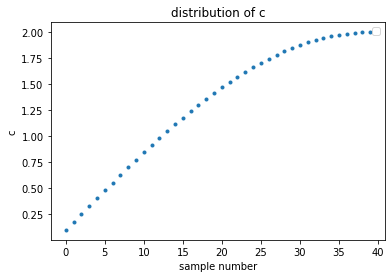

In [ ]:
len_train_C=40
len_train_sig=40
len_total=len_train_C*len_train_sig
train_labels = []
list_c_train = []
T=0.34
train_set = []
iterations = 1

Cmin=0.1
Cmax=2
Smin=0.08
Smax=0.15

C=(Cmax-Cmin)*np.sin(np.linspace(0,np.pi/2,len_train_C))+Cmin # Fonction sinus
sigma=(Smax-Smin)*np.sin(np.linspace(0,np.pi/2,len_train_sig))+Smin
#sigma=np.linspace(0.08,0.15,len_train_sig)
plt.plot(C,'.')
plt.title('distribution of c')
plt.ylabel('c')
plt.xlabel('sample number')
plt.legend()

No handles with labels found to put in legend.


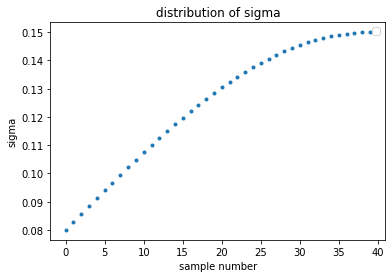

In [ ]:
plt.plot(sigma,'.')
plt.title('distribution of sigma')
plt.ylabel('sigma')
plt.xlabel('sample number')
plt.legend()

In [ ]:
for sig in sigma:
  for c in C:
    clear_output()
    print('{}/'.format(iterations)+str(len_total))
    list_c_train =list_c_train+[c,c]
    diff_data, wave_data = get_samples(c,T,sig)
    diff_data=np.append(diff_data,[sig])
    wave_data=np.append(wave_data,[sig])
    train_set.append(diff_data)
    train_set.append(wave_data)
    train_labels= train_labels+[0,1]
    iterations=iterations+1

train_set = np.array(train_set)
train_labels= np.array(train_labels)
list_c_train=np.array(list_c_train)
sol_len=len(train_set[0])

1600/1600


Dans le plot ci-dessous, à la même couleur est attribué à un ensemble de solutions avec c identique mais des sigmas differents.

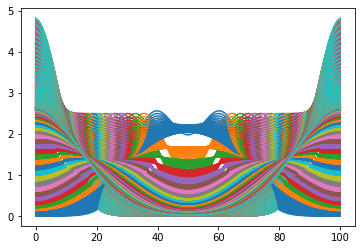

In [ ]:
for i in range(len_total):
  plt.plot(train_set[2*i+1][:-1])

De même pour les solutions diffusions.

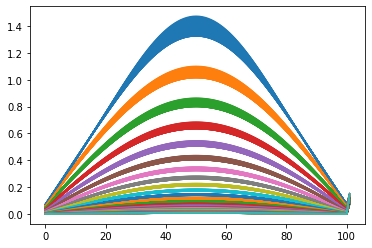

In [ ]:
for i in range(len_total):
  plt.plot(train_set[2*i])

La prediction de w utilise un réseau de deux couches.

In [ ]:
model_w = Sequential()
model_w.add(layers.Dense(50, activation='relu', input_dim=sol_len))
model_w.add(layers.Dense(1, activation='sigmoid'))

print(model_w.summary())

model_w.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                5150      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:

model_w.fit(train_set,
          train_labels,
          batch_size=500,
          epochs=100,
          validation_split=0.2,
          verbose=1)




Train on 2560 samples, validate on 640 samples
Epoch 1/100





2560/2560 [==============================] - 1s 242us/step - loss: 0.7075 - acc: 0.5465 - val_loss: 0.4357 - val_acc: 0.8000
Epoch 2/100
2560/2560 [==============================] - 0s 9us/step - loss: 0.4195 - acc: 0.8527 - val_loss: 0.3942 - val_acc: 0.9500
Epoch 3/100
2560/2560 [==============================] - 0s 9us/step - loss: 0.3837 - acc: 0.9277 - val_loss: 0.3756 - val_acc: 0.9750
Epoch 4/100
2560/2560 [==============================] - 0s 9us/step - loss: 0.3635 - acc: 0.9645 - val_loss: 0.3594 - val_acc: 0.9375
Epoch 5/100
2560/2560 [==============================] - 0s 8us/step - loss: 0.3506 - acc: 0.9484 - val_loss: 0.3472 - val_acc: 0.9250
Epoch 6/100
2560/2560 [==============================] - 0s 9us/step - loss: 0.3394 - acc: 0.9574 - val_loss: 0.3361 - val_acc: 0.9500
Epoch 7/100
2560/2560 [==============================] - 0s 10us/step - loss: 0.3279 - acc: 0.9742 - val_loss: 0.3278 - val_acc: 0.97

Ici je crée un ensemble test de 15 valeurs differentes de c et sigma soit 225 valeurs pour la diffusion et l'onde séparément. C et sigma sont distribués lineairement dans l'intervalle d'entrainement.

In [ ]:
len_test_C=15
len_test_sig=15
len_test_total=len_test_C*len_test_sig
test_labels = []
list_c_test = []
test_set = []
iterations = 1

sigma_test=np.linspace(Smin,Smax,len_test_sig)
C_test=np.linspace(Cmin,Cmax,len_test_C)

for c in C_test:
  for sig in sigma_test:
    clear_output()
    print('{}/'.format(iterations)+str(len_test_total))
    list_c_test =list_c_test+[c,c]
    diff_data, wave_data = get_samples(c,T,sig)
    diff_data=np.append(diff_data,[sig])
    wave_data=np.append(wave_data,[sig])
    test_set.append(diff_data)
    test_set.append(wave_data)
    test_labels= test_labels+[0,1]
    iterations=iterations+1

test_set = np.array(test_set)
test_labels= np.array(test_labels)
list_c_test=np.array(list_c_test)
sol_len=len(test_set[0])

225/225


Le separateur entre les deux classes 0 et 1 est 0.5

In [ ]:
pred=model_w.predict(test_set)
prediction_w=[]
for p in pred:
  if p[0]>0.5:
    prediction_w=prediction_w+[1]
  else:
    prediction_w=prediction_w+[0]

prediction_w=np.array(prediction_w)

In [ ]:
frequence_error=(prediction_w!=test_labels).sum()/(len_test_total*2)

print("The frequence of errors on w is ", round(frequence_error,3))

The frequence of errors on w is  0.0


La frequence 1/30, a augmenté par rapport au cas ou sigma était fixé. Auparavant on avait 0.0025=1/400 

Dans cette partie, c est predie pour la diffusion.

In [ ]:
train_set_diffusion=[]
train_c_diffusion=[]
for i in range(len_total):
  train_set_diffusion=train_set_diffusion+[train_set[2*i]]
  train_c_diffusion=train_c_diffusion+[list_c_train[2*i]]

train_set_diffusion=np.array(train_set_diffusion)
train_c_diffusion=np.array(train_c_diffusion)

Le model à 4 couches donne des meilleurs performence dans le cas de sigma non fixé.

In [ ]:
model_c_dif = Sequential()
model_c_dif.add(layers.Dense(75, activation='relu', input_dim=sol_len))
model_c_dif.add(layers.Dense(50, activation='relu'))
model_c_dif.add(layers.Dense(25, activation='relu'))
model_c_dif.add(layers.Dense(1,activation='linear'))

print(model_c_dif.summary())

model_c_dif.compile(loss='mean_absolute_error', optimizer='Adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 75)                7725      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26        
Total params: 12,826
Trainable params: 12,826
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_c_dif.fit(train_set_diffusion,
          train_c_diffusion,
          batch_size=5,
          epochs=30,
          validation_split=0.2,
          verbose=1)

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 1s 558us/step - loss: 0.2963 - val_loss: 0.0422
Epoch 2/30
1280/1280 [==============================] - 0s 338us/step - loss: 0.0388 - val_loss: 0.0247
Epoch 3/30
1280/1280 [==============================] - 0s 320us/step - loss: 0.0260 - val_loss: 0.0214
Epoch 4/30
1280/1280 [==============================] - 0s 329us/step - loss: 0.0215 - val_loss: 0.0103
Epoch 5/30
1280/1280 [==============================] - 0s 309us/step - loss: 0.0134 - val_loss: 0.0116
Epoch 6/30
1280/1280 [==============================] - 0s 323us/step - loss: 0.0162 - val_loss: 0.0109
Epoch 7/30
1280/1280 [==============================] - 0s 313us/step - loss: 0.0146 - val_loss: 0.0313
Epoch 8/30
1280/1280 [==============================] - 0s 310us/step - loss: 0.0130 - val_loss: 0.0218
Epoch 9/30
1280/1280 [==============================] - 0s 303us/step - loss: 0.0107 - val_loss: 0.0064
Epoch 10/30
1280/

test_set_diffusion est cree pour tester le model.

In [ ]:
test_set_diffusion=[]
test_c_diffusion=[]
for i in range(len_test_total):
  test_set_diffusion=test_set_diffusion+[test_set[2*i]]
  test_c_diffusion=test_c_diffusion+[list_c_test[2*i]]
  
test_set_diffusion=np.array(test_set_diffusion)
test_c_diffusion=np.array(test_c_diffusion)

In [ ]:
pred_c=model_c_dif.predict(test_set_diffusion)
prediction=[]
for t in pred_c:
    prediction=prediction+[t[0]]
prediction=np.asarray(prediction)

variance=sum(abs(prediction-test_c_diffusion))/len(test_c_diffusion)
print("L'erreur moyenne est ",round(variance,3))

L'erreur moyenne est  0.009


L'erreur moyenne se situe proche du cas ou sigma est fixe, c'est à dire 0.011. Le plot ci-dessous represente des paliés pour lequel c est fixe mais sigma varie.

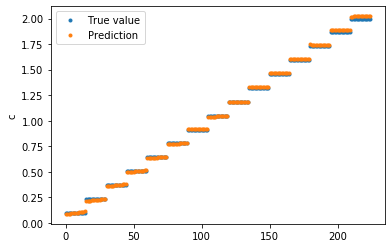

In [ ]:
plt.plot(test_c_diffusion,'.',label="True value")
plt.plot(pred_c,'.', label="Prediction")
plt.ylabel('c')
plt.legend()

Prediction de c pour la wave.

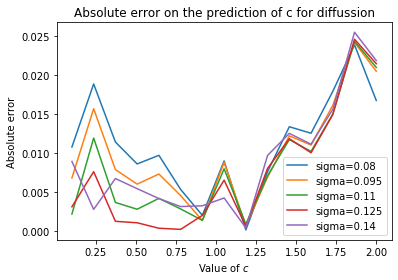

In [ ]:
abs_err_c_diffusion=np.linalg.norm(test_c_diffusion - pred_c.T,axis=0)
plt.figure()

for s in range(int(len_test_sig/3)):
  y=[]
  x=[]
  for i in range(len_test_C):
    y=y+[abs_err_c_diffusion[15*i+3*s]]
    x=x+[test_c_diffusion[15*i+3*s]]
  plt.plot(x,y,label='sigma='+str(round(sigma_test[3*s],3)))

plt.title("Absolute error on the prediction of c for diffussion")
plt.xlabel("Value of $c$")
plt.ylabel('Absolute error')
plt.legend()
plt.show()

In [ ]:
train_set_wave=[]
train_c_wave=[]
for i in range(len_total):
  train_set_wave=train_set_wave+[train_set[2*i+1]]
  train_c_wave=train_c_wave+[list_c_train[2*i+1]]
  
train_set_wave=np.array(train_set_wave)
train_c_wave=np.array(train_c_wave)

De même que pour la diffusion, le model a 4 couches denses.

In [ ]:
model_c_wave = Sequential()
model_c_wave.add(layers.Dense(75, activation='relu', input_dim=sol_len))
model_c_wave.add(layers.Dense(50, activation='relu'))
model_c_wave.add(layers.Dense(25, activation='relu'))
model_c_wave.add(layers.Dense(1,activation='linear'))

print(model_c_wave.summary())

model_c_wave.compile(loss='mean_squared_error', optimizer='adam')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 75)                7725      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_9 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 26        
Total params: 12,826
Trainable params: 12,826
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_c_wave.fit(train_set_wave,
          train_c_wave,
          batch_size=50,
          epochs=80,
          validation_split=0.2,
          verbose=1)

Train on 1280 samples, validate on 320 samples
Epoch 1/80
1280/1280 [==============================] - 0s 298us/step - loss: 0.2554 - val_loss: 0.0576
Epoch 2/80
1280/1280 [==============================] - 0s 38us/step - loss: 0.0193 - val_loss: 0.0315
Epoch 3/80
1280/1280 [==============================] - 0s 40us/step - loss: 0.0151 - val_loss: 0.0246
Epoch 4/80
1280/1280 [==============================] - 0s 40us/step - loss: 0.0130 - val_loss: 0.0227
Epoch 5/80
1280/1280 [==============================] - 0s 39us/step - loss: 0.0111 - val_loss: 0.0275
Epoch 6/80
1280/1280 [==============================] - 0s 38us/step - loss: 0.0100 - val_loss: 0.0247
Epoch 7/80
1280/1280 [==============================] - 0s 40us/step - loss: 0.0094 - val_loss: 0.0284
Epoch 8/80
1280/1280 [==============================] - 0s 40us/step - loss: 0.0091 - val_loss: 0.0172
Epoch 9/80
1280/1280 [==============================] - 0s 41us/step - loss: 0.0080 - val_loss: 0.0135
Epoch 10/80
1280/1280 [==

Teste du model:

In [ ]:
test_set_wave=[]
test_c_wave=[]
for i in range(len_test_total):
  test_set_wave=test_set_wave+[test_set[2*i+1]]
  test_c_wave=test_c_wave+[list_c_test[2*i+1]]
  
test_set_wave=np.array(test_set_wave)
test_c_wave=np.array(test_c_wave)

In [ ]:
pred_c_wave=model_c_wave.predict(test_set_wave)
prediction_wave=[]
for t in pred_c_wave:
    prediction_wave=prediction_wave+[t[0]]
prediction_wave=np.asarray(prediction_wave)

variance=sum(abs(prediction_wave-test_c_wave))/len(test_c_wave)
print("L'erreur moyenne est ",round(variance,3))

L'erreur moyenne est  0.025


L'erreur moyenne a augmenté. Dans le cas ou sigma est fixé, l'erreur était de 0.005. On observe une difficulté de prédiction pour des c grand.

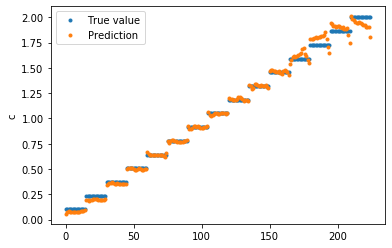

In [ ]:
plt.plot(test_c_wave,'.',label="True value")
plt.plot(pred_c_wave,'.', label="Prediction")
plt.ylabel('c')
plt.legend()

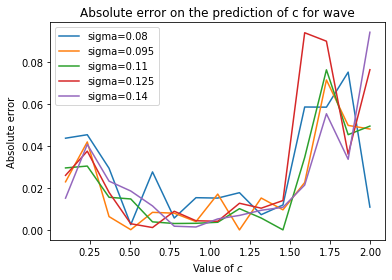

In [ ]:
abs_err_c_wave=np.linalg.norm(test_c_wave - pred_c_wave.T,axis=0)
plt.figure()

for s in range(int(len_test_sig/3)):
  y=[]
  x=[]
  for i in range(len_test_C):
    y=y+[abs_err_c_wave[15*i+3*s]]
    x=x+[test_c_wave[15*i+3*s]]
  plt.plot(x,y,label='sigma='+str(round(sigma_test[3*s],3)))

plt.title("Absolute error on the prediction of c for wave")
plt.xlabel("Value of $c$")
plt.ylabel('Absolute error')
plt.legend()
plt.show()